<figure>
   <IMG SRC="https://mamba-python.nl/images/logo_basis.png" WIDTH=125 ALIGN="right">
   
</figure>

# Analyse data CBR
<br>

**Doel**: 
Data downloaden van het CBR en analyseren.

**stappen**
1. inlezen data
2. combineren van data
3. visualiseren van data

**Gegevens**
- geboortes per 1000 inwoners
- gemeentegrenzen

table of content:<a class="anchor" id="0"></a>
1. [inlezen](#1)
2. [combineren data](#2)
3. [visualiseren](#3)


[back to TOC](#0)
## 1. inlezen data<a class="anchor" id="1"></a>

In [1]:
import pandas as pd
import geopandas as gpd
import requests
import matplotlib.pyplot as plt

In [2]:
#settings
%matplotlib inline
plt.style.use('default')

#### gemeentegrenzen
De gemeentegrenzen worden via de API van het Nationaal Georegister van PDOK opgehaald. 

In [3]:
geodata_url = "https://geodata.nationaalgeoregister.nl/cbsgebiedsindelingen/wfs?request=GetFeature&service=WFS&version=2.0.0&typeName=cbs_gemeente_2017_gegeneraliseerd&outputFormat=json"
gemeentegrenzen = gpd.read_file(geodata_url)

#### CBR geboortecijfers
De geboortecijfers worden via de API van het CBS opgehaald.

In [4]:
def get_odata(target_url):
    data = pd.DataFrame()
    while target_url:
        r = requests.get(target_url).json()
        data = data.append(pd.DataFrame(r['value']))
        
        if '@odata.nextLink' in r:
            target_url = r['@odata.nextLink']
        else:
            target_url = None
            
    return data

In [5]:
# Zoek op welke codes bij geboortecijfers horen
table_url = "https://beta-odata4.cbs.nl/CBS/83765NED"
codes = get_odata(table_url + "/MeasureCodes")
geb = codes[codes['Title'].str.contains("Geboorte")]
print(geb[['Title','Unit','Identifier']])

                Title                Unit Identifier
19    Geboorte totaal              aantal  M000173_1
20  Geboorte relatief  per 1 000 inwoners  M000173_2


In [6]:
target_url = table_url + "/Observations?$filter=Measure eq 'M000173_2' and startswith(WijkenEnBuurten,'GM')"
geboorten_per_gemeente = get_odata(target_url)
geboorten_per_gemeente['WijkenEnBuurten'] = geboorten_per_gemeente['WijkenEnBuurten'].str.strip()
geboorten_per_gemeente = geboorten_per_gemeente.rename({'Value':'relatieve_geboorte'}, axis='columns')
geboorten_per_gemeente

,Id,Measure,ValueAttribute,relatieve_geboorte,WijkenEnBuurten
0,123,M000173_2,None,6.0,GM1680
1,7951,M000173_2,None,10.0,GM0738
2,10320,M000173_2,None,7.0,GM0358
3,11659,M000173_2,None,8.0,GM0197
4,15161,M000173_2,None,9.0,GM0059
...,...,...,...,...,...
383,1686542,M000173_2,None,7.0,GM0879
384,1688293,M000173_2,None,8.0,GM0301
385,1692207,M000173_2,None,12.0,GM1896
386,1696430,M000173_2,None,11.0,GM0642


[back to TOC](#0)

## 2. samenvoegen data<a class="anchor" id="2"></a>

Gebruik de `merge` functie om de gemeentegrenzen te koppelen aan de geboortecijfers per gemeente.

In [7]:
geboorten_merged = pd.merge(gemeentegrenzen, geboorten_per_gemeente, left_on = "statcode", right_on = "WijkenEnBuurten")


[back to TOC](#0)

## 3. visualisatie<a class="anchor" id="3"></a>

Text(0.5, 1.0, 'Levend geborenen per 1000 inwoners, 2017')

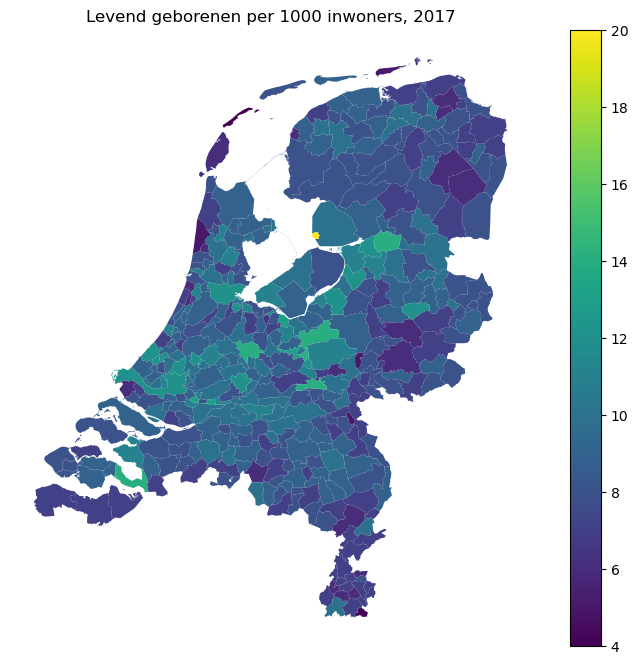

In [8]:
fig, ax = plt.subplots(figsize = (10,8))
p = geboorten_merged.plot(column='relatieve_geboorte', ax=ax, legend=True)
p.axis('off')
p.set_title("Levend geborenen per 1000 inwoners, 2017")

[back to TOC](#0)

## Acknowledgement <a class="anchor" id="4"></a>

Deze notebook is gemaakt met behulp van de volgende bronnen:

- https://github.com/statistiekcbs/CBS-Open-Data-v4

